In [66]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
import pickle

# Define the paths to the folders containing the gradients
gradients_high_folder = 'grad_mar_high/'
gradients_low_folder = 'grad_mar_low/'


# Load the gradients from the folders
gradients_high = []
gradients_low = []

In [67]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


In [68]:
#Acess the data and create training and testing datasets
for i in range(100):
    with open(os.path.join(gradients_high_folder, f'gradients_high_iter_{i}.pkl'), 'rb') as f:
        gradient_high = pickle.load(f)
        gradients_high.append(gradient_high)

    with open(os.path.join(gradients_low_folder, f'gradients_low_iter_{i}.pkl'), 'rb') as f:
        gradient_low = pickle.load(f)
        gradients_low.append(gradient_low)

In [70]:
gradients_high[0].shape


torch.Size([601, 221])

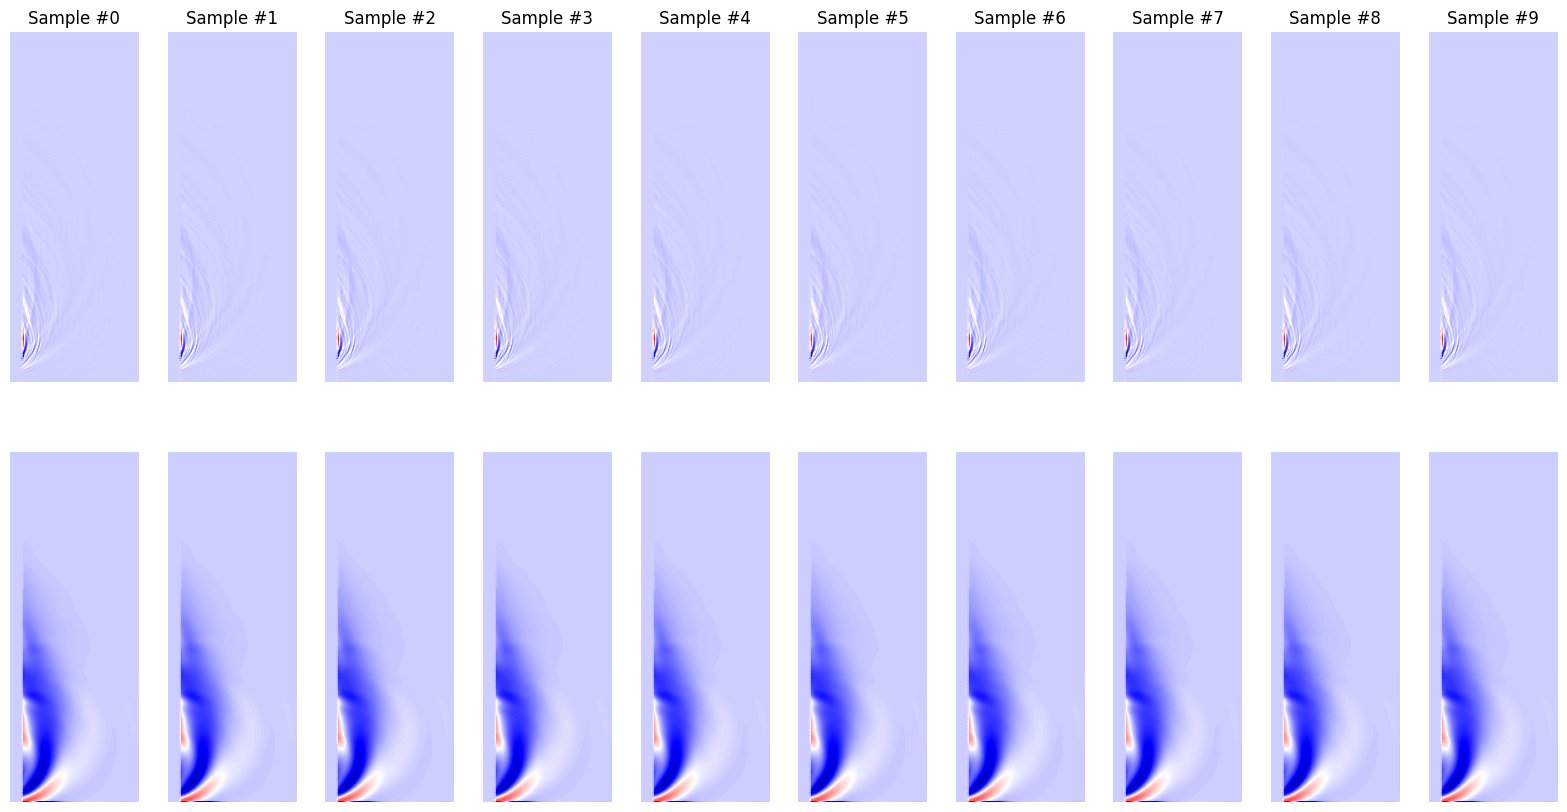

In [73]:
import matplotlib.pyplot as plt
ncols = 10

fig, axs = plt.subplots(2, ncols, figsize=(20, 10))
for i in range(ncols):
    image, mask = gradients_high[0].cpu(), gradients_low[0].cpu()
    axs[0, i].imshow(image, cmap='seismic')
    axs[0, i].set_title('Sample #{}'.format(i))
    axs[0, i].axis('off')
    axs[1, i].imshow(mask, cmap='seismic')
    axs[1, i].axis('off')

In [74]:
import torch
from torch.utils.data import TensorDataset
def create_dataset(gradients_high_list, gradients_low_list, device):
    gradients_low_norm = []
    gradients_high_norm =[]
    for i in range(len(gradients_high_list)):
        gradients_high = gradients_high_list[i]
        gradients_low = gradients_low_list[i]

#         # Calculate normalization factors for each pair of gradients
#         max_value = torch.max(torch.abs(gradients_high))
#         normalization_factor = 1 / max_value

#         max_value_low = torch.max(torch.abs(gradients_low))
#         normalization_factor_low = 1 / max_value_low

#         # Normalize gradients
#         gradients_low_norm0 = gradients_low * normalization_factor
#         gradients_high_norm0 = gradients_high * normalization_factor


        # Add a channel dimension
        gradients_low_norm1 = gradients_low.unsqueeze(0)
        gradients_high_norm1 = gradients_high.unsqueeze(0)
        
        # # Add a channel dimension
        # gradients_low_norm1 = gradients_low_norm0.unsqueeze(0)
        # gradients_high_norm1 = gradients_high_norm0.unsqueeze(0)
        
        gradients_low_norm.append(gradients_low_norm1)
        gradients_high_norm.append(gradients_high_norm1)
        
    return gradients_low_norm,gradients_high_norm




In [75]:
gradients_low_norm,gradients_high_norm = create_dataset(gradients_high, gradients_low, device)

In [76]:

# Convert gradients to tensors and stack them
gradients_high = torch.stack(gradients_high_norm)
print(gradients_high.shape)
gradients_low = torch.stack(gradients_low_norm)

# Define the dataset using the gradients
dataset = TensorDataset(gradients_high.float().to(device), gradients_low.float().to(device))

torch.Size([70, 1, 601, 221])


In [78]:
# # Split the dataset into train and test sets
# train_size = int(0.90 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Create dataloaders batch_size=batch_size
# batch_size = 16
# train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)

# # Print the sizes of train and test datasets
# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

In [79]:
# Calculate sizes for train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders for train, validation, and test sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print the sizes of train, validation, and test datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 56
Validation dataset size: 7
Test dataset size: 7


In [80]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# for inputs, targets in train_loader:
#     a = inputs
#     b= targets
#     break
    
# # a.shape, b.shape

# # dataiter = iter(train_dataloader)
# # image, label = dataiter.next()
# # print(gradients_high.shape)
# conv1 = nn.Conv2d(1, 32, 3)
# conv1.cuda()
# pool = nn.MaxPool2d(2, 2)
# pool.cuda()
# conv2 = nn.Conv2d(32, 64, 3)
# conv2.cuda()
# pool = nn.MaxPool2d(2, 2)
# pool.cuda()
# conv3 = nn.Conv2d(64, 128, 3)
# conv3.cuda()
# # a=gradients_low[0].cuda()
# x=conv1(a)
# x=pool(x)
# x=conv2(x)
# x=pool(x)
# print(x.shape)
# x=conv3(x)
# x=pool(x)
# print(x.shape)

In [82]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 148 * 53, 128)
        self.dropout1 = nn.Dropout(0.3)  # Use separate dropout instances
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 601 * 221)

        # Initialize weights using Xavier initialization
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 148 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x).view(-1, 1, 601, 221)
        return x






model = ConvNet()
model = model.cuda()  # Move the model to GPU if available

In [84]:
#count trainable parameters of the model
def count_parameters(network):
    return sum(p.numel() for p in network.parameters() if p.requires_grad)

count_parameters(model)

72918613

In [51]:
for inputs,outputs in train_loader:
    a=inputs
    b=outputs
    break
print(a.shape)
print(b.shape)

torch.Size([16, 1, 601, 221])
torch.Size([16, 1, 601, 221])


In [54]:
model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=502016, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=132821, bias=True)
)

In [56]:
# Define the loss function and optimizer, weight_decay=0.01, lr=0.001
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1), weight_decay=0.00001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.0001)


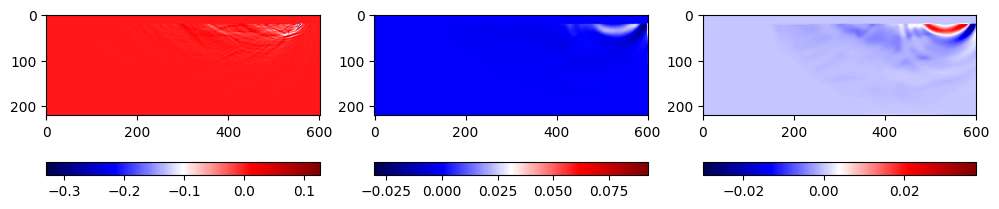

Epoch 10/500, Train Loss: 5.480385425471468e-06, Valid Loss: 3.586474576877663e-06


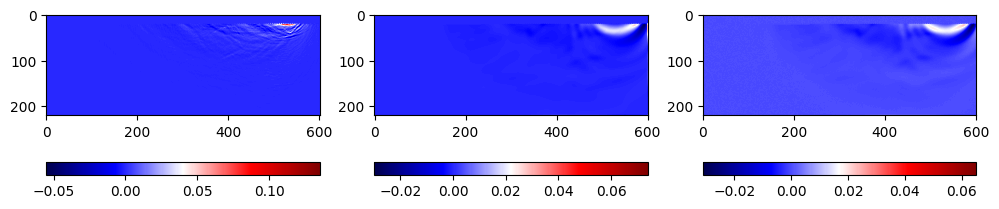

Epoch 20/500, Train Loss: 5.1070911126771534e-06, Valid Loss: 3.3080705179600045e-06


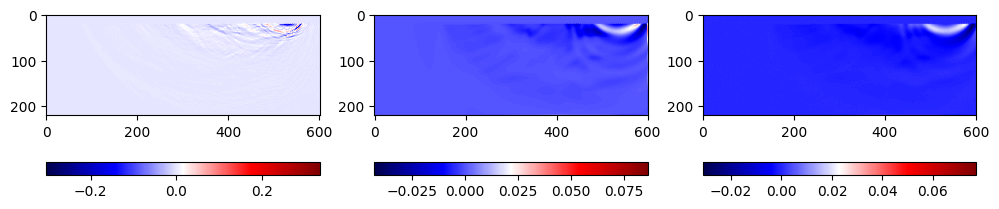

Epoch 30/500, Train Loss: 4.318147318826959e-06, Valid Loss: 3.3382580113539007e-06


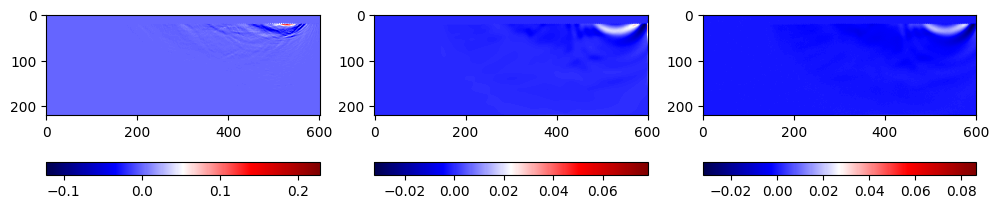

Epoch 40/500, Train Loss: 5.7423389989708085e-06, Valid Loss: 3.2623820516164415e-06


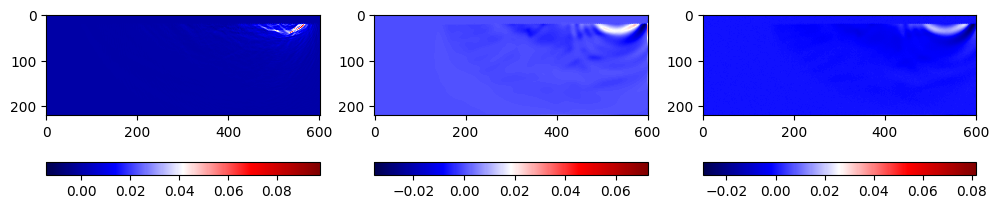

Epoch 50/500, Train Loss: 3.899162550169422e-06, Valid Loss: 2.7570010843191994e-06


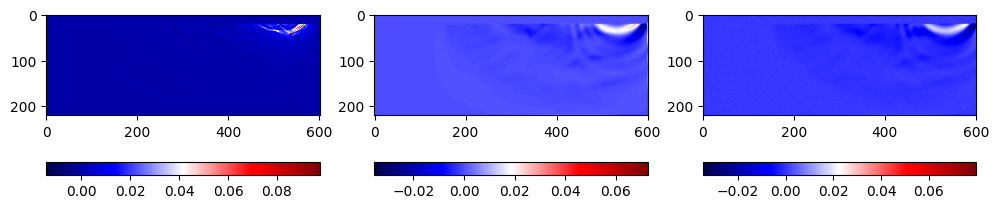

Epoch 60/500, Train Loss: 2.729907237153384e-06, Valid Loss: 1.9862022782035638e-06


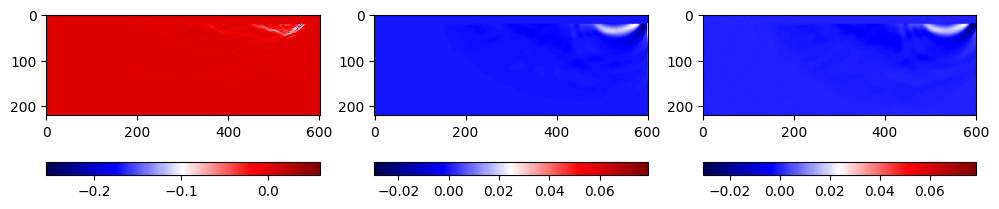

Epoch 70/500, Train Loss: 2.2759352020784718e-06, Valid Loss: 1.02815658920008e-06


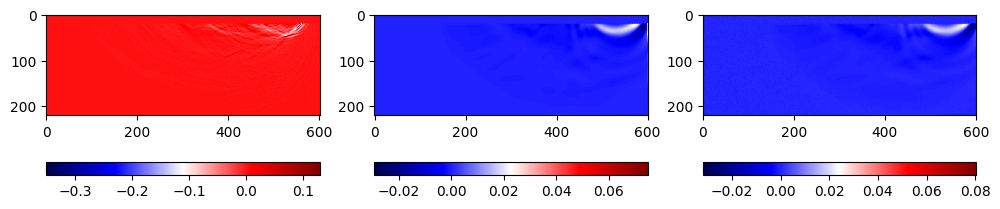

Epoch 80/500, Train Loss: 1.469707910928264e-06, Valid Loss: 6.503025815618457e-07


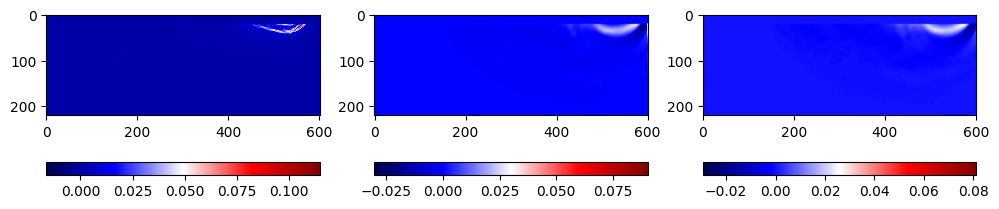

Epoch 90/500, Train Loss: 2.0763384611655056e-06, Valid Loss: 6.541145012306515e-07


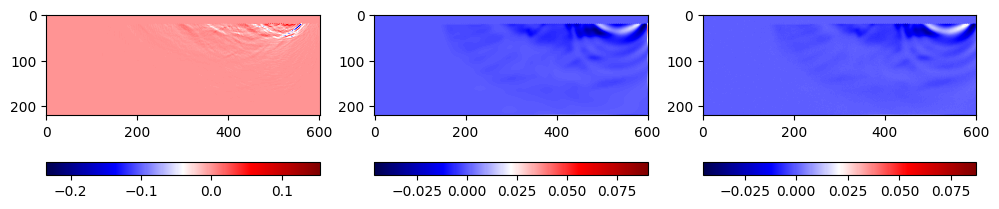

Epoch 100/500, Train Loss: 1.0572537263442428e-06, Valid Loss: 7.825624379620422e-07


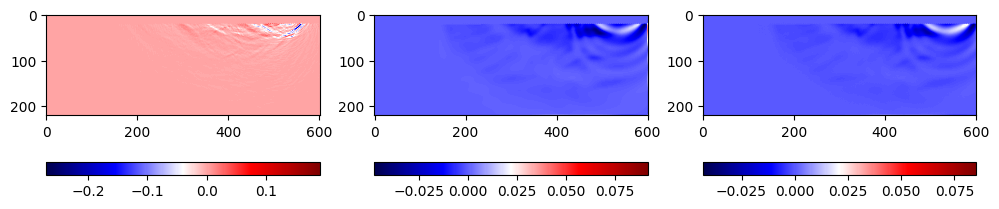

Epoch 110/500, Train Loss: 1.4967575054924964e-06, Valid Loss: 4.476667641029053e-07


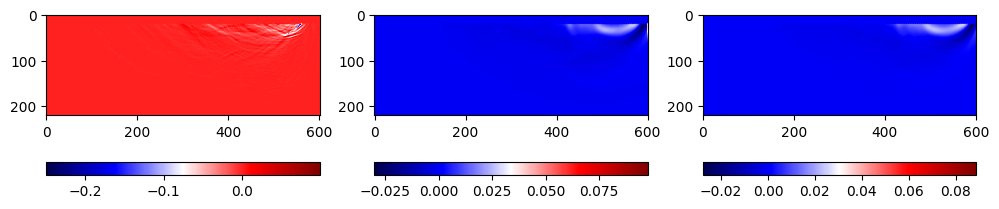

Epoch 120/500, Train Loss: 1.275898881658577e-06, Valid Loss: 5.577467163675465e-07


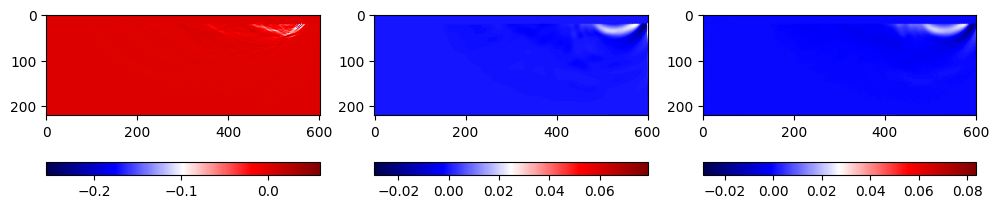

Epoch 130/500, Train Loss: 1.3459072221166934e-06, Valid Loss: 5.035147410126228e-07


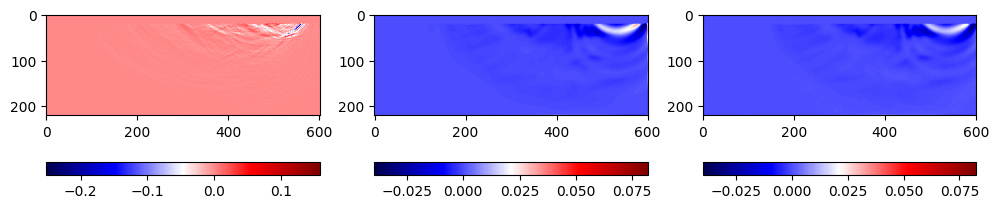

Epoch 140/500, Train Loss: 8.210544422126986e-07, Valid Loss: 6.458001280407188e-07


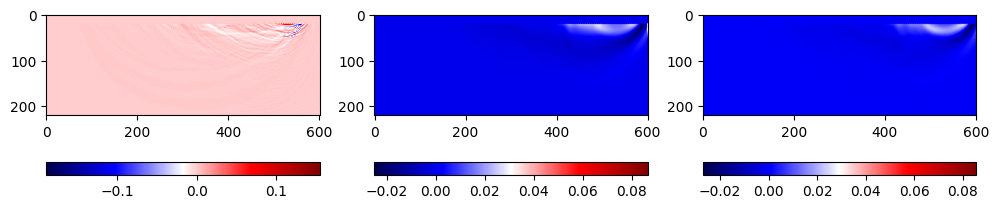

Epoch 150/500, Train Loss: 1.5336799776832777e-06, Valid Loss: 5.645666192322096e-07


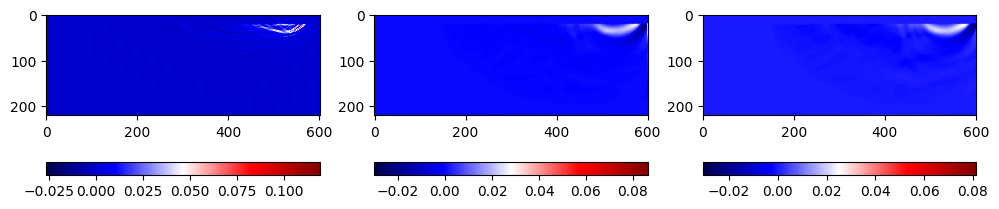

Epoch 160/500, Train Loss: 1.2599796406220776e-06, Valid Loss: 4.38108514799751e-07


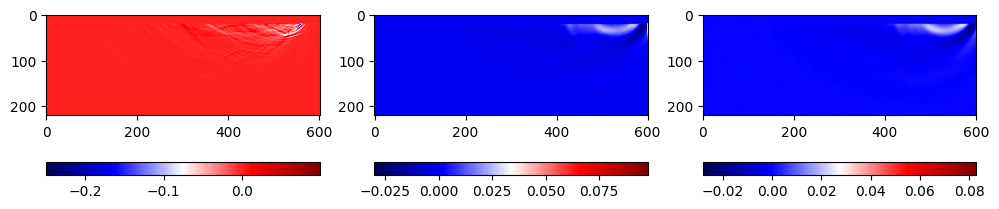

Epoch 170/500, Train Loss: 1.0578699232155486e-06, Valid Loss: 5.286360647005495e-07


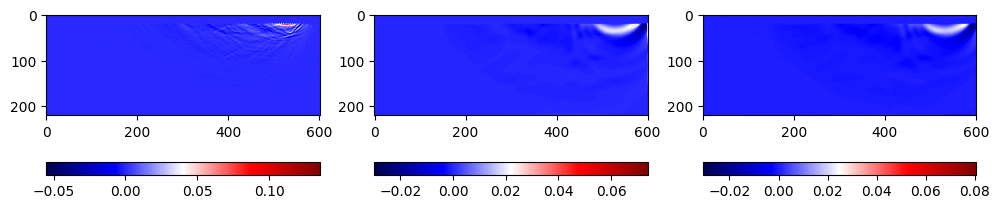

Epoch 180/500, Train Loss: 1.1762298299800023e-06, Valid Loss: 4.918803711007058e-07


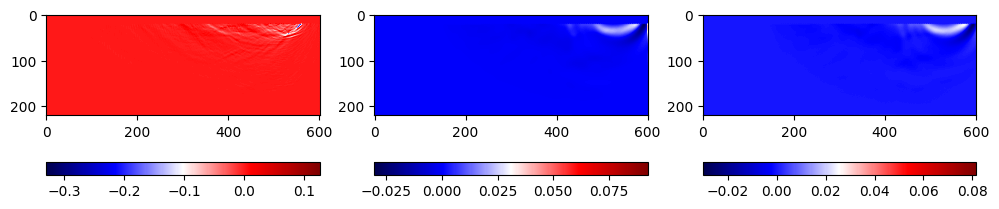

Epoch 190/500, Train Loss: 6.213417194089743e-07, Valid Loss: 7.084624371600512e-07


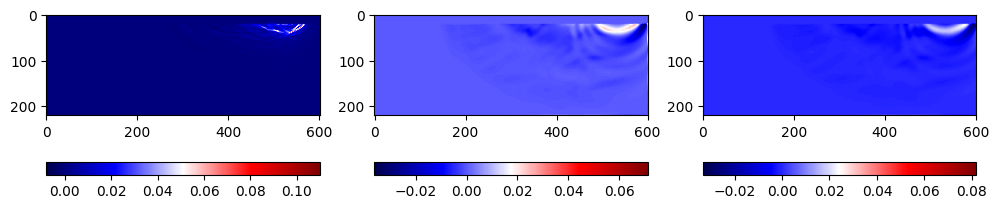

Epoch 200/500, Train Loss: 7.022105990017735e-07, Valid Loss: 3.27616845652301e-07


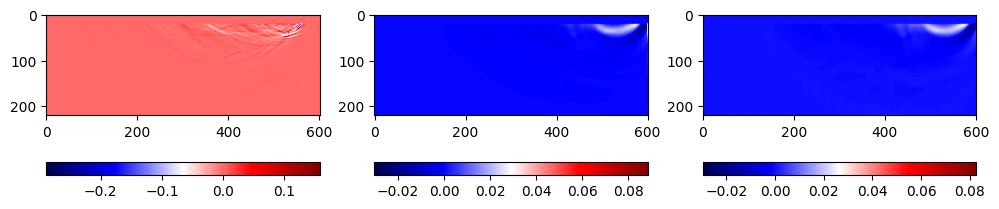

Epoch 210/500, Train Loss: 2.44665037030245e-06, Valid Loss: 7.570607749585179e-07


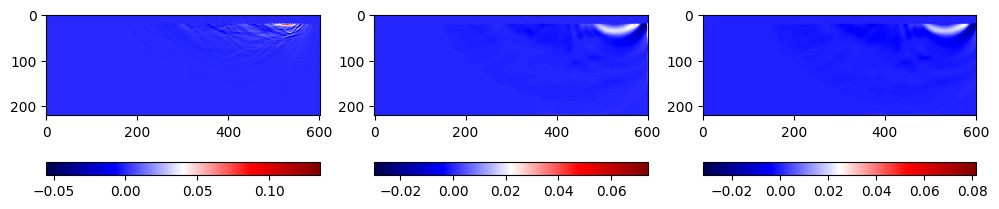

Epoch 220/500, Train Loss: 9.748364426798162e-07, Valid Loss: 5.724765514969476e-07


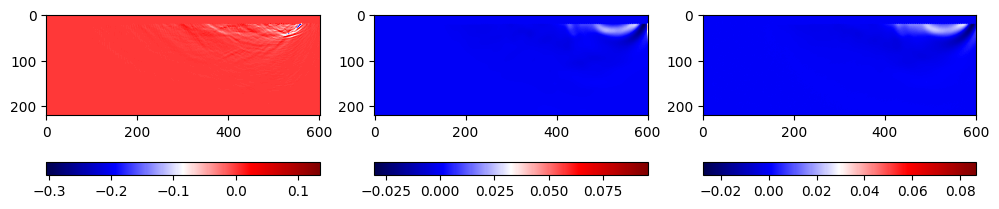

Epoch 230/500, Train Loss: 1.0826598497715167e-06, Valid Loss: 4.5816025817657646e-07


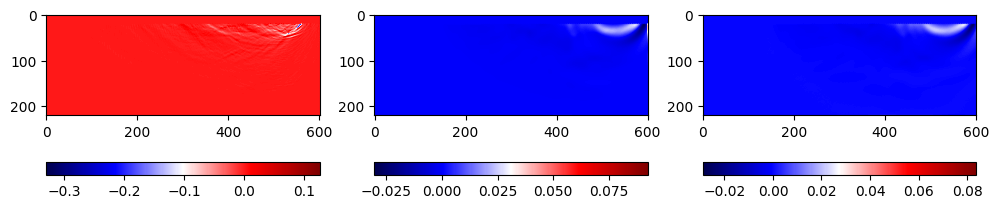

Epoch 240/500, Train Loss: 1.7295159864261223e-06, Valid Loss: 7.135241730793496e-07


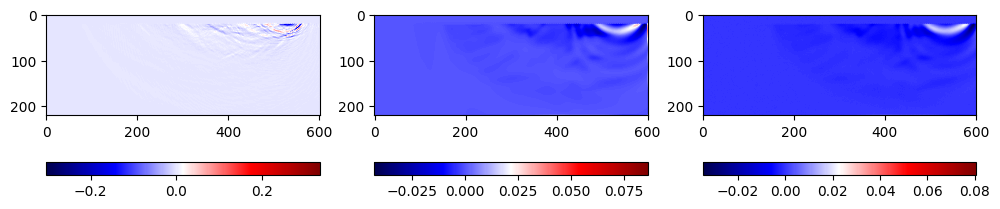

Epoch 250/500, Train Loss: 1.034250431075634e-06, Valid Loss: 4.870202019446879e-07


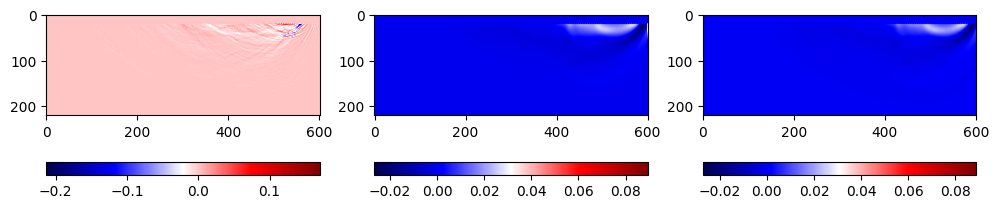

Epoch 260/500, Train Loss: 1.2351220348705283e-06, Valid Loss: 4.637241488580912e-07


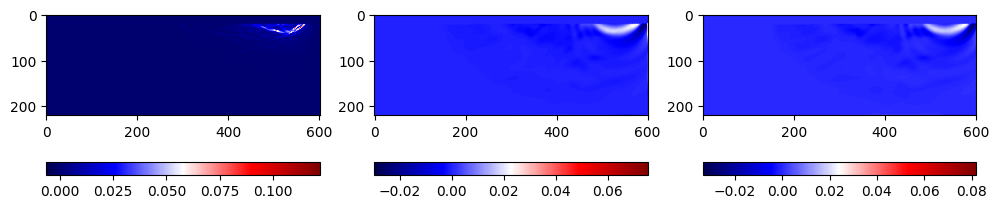

Epoch 270/500, Train Loss: 6.896285000834723e-07, Valid Loss: 4.342697650372429e-07


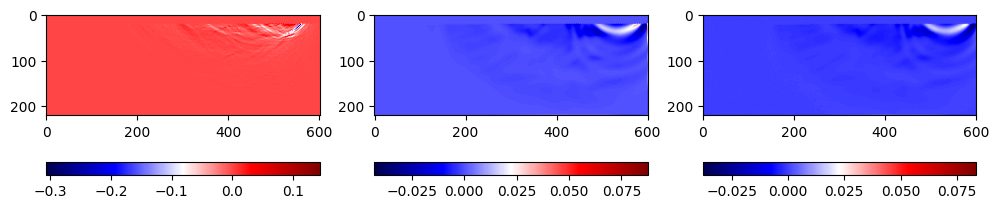

Epoch 280/500, Train Loss: 7.125111523009764e-07, Valid Loss: 4.7655740331720153e-07


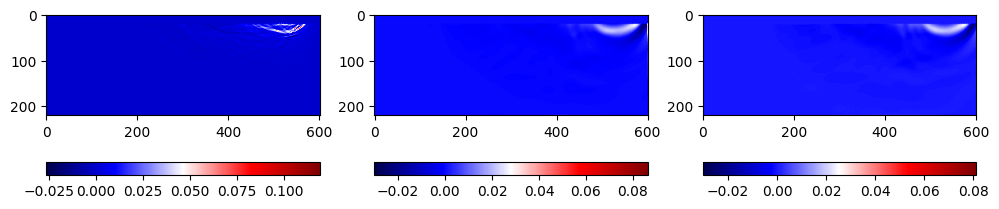

Epoch 290/500, Train Loss: 1.050326375207078e-06, Valid Loss: 3.902754031059885e-07


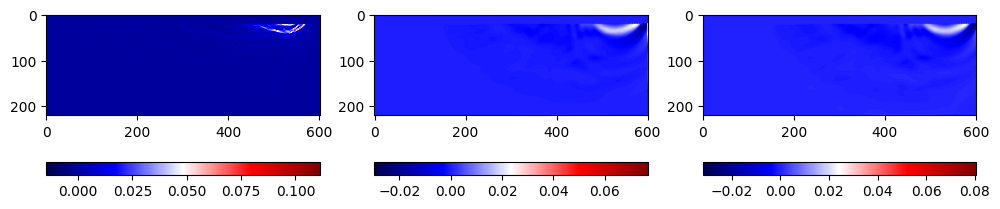

Epoch 300/500, Train Loss: 8.496108989675122e-07, Valid Loss: 5.878284810023615e-07


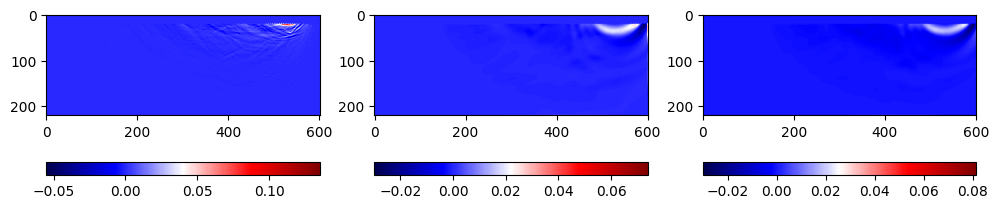

Epoch 310/500, Train Loss: 9.332412673757062e-07, Valid Loss: 8.387809771193133e-07


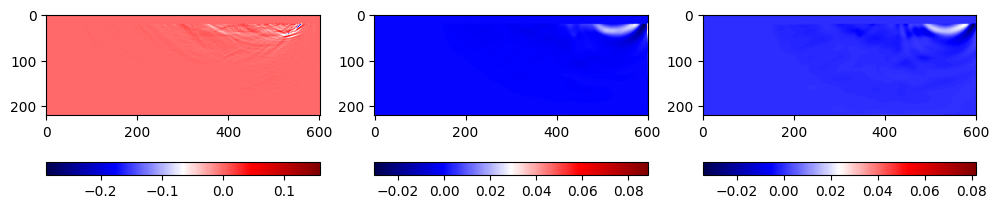

Epoch 320/500, Train Loss: 1.0194556949727485e-06, Valid Loss: 4.7564009264533524e-07


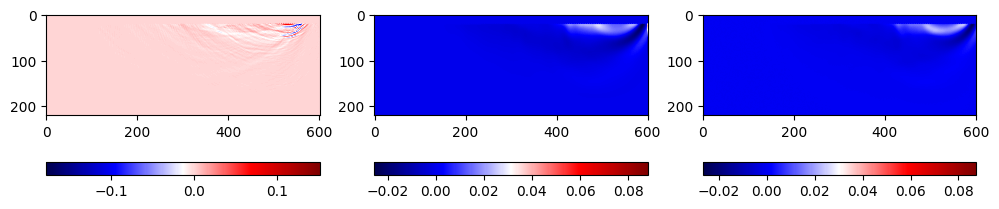

Epoch 330/500, Train Loss: 1.1398093491266081e-06, Valid Loss: 5.438772632260225e-07


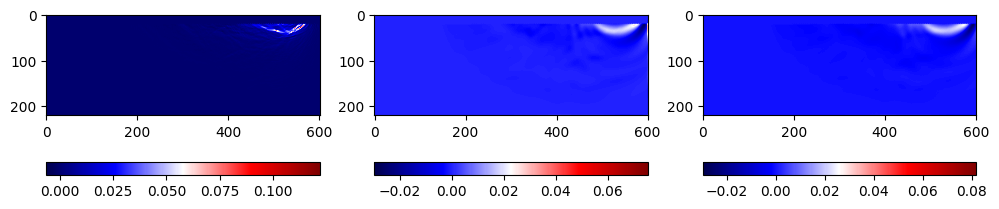

Epoch 340/500, Train Loss: 1.2334323571394634e-06, Valid Loss: 8.120053394122806e-07


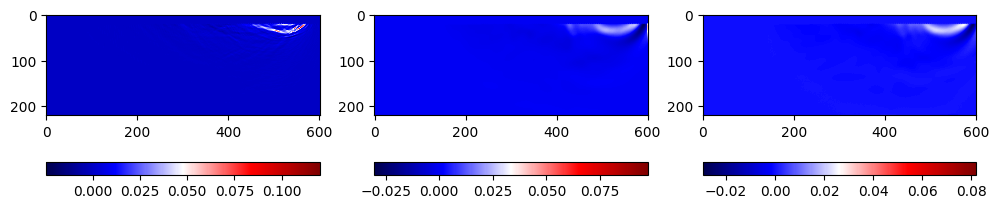

Epoch 350/500, Train Loss: 1.6013677779369573e-06, Valid Loss: 5.254603365756338e-07


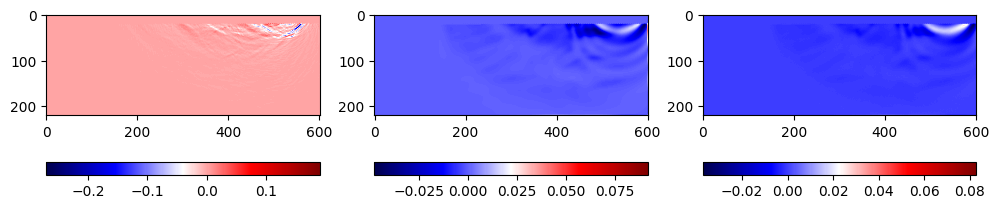

Epoch 360/500, Train Loss: 8.482993649749915e-07, Valid Loss: 5.5922851061041e-07


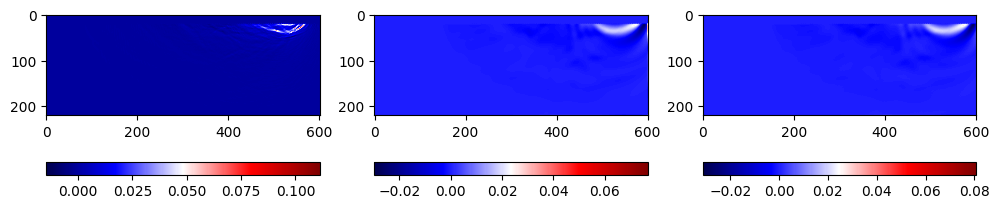

Epoch 370/500, Train Loss: 8.908668363005745e-07, Valid Loss: 4.049986159770924e-07


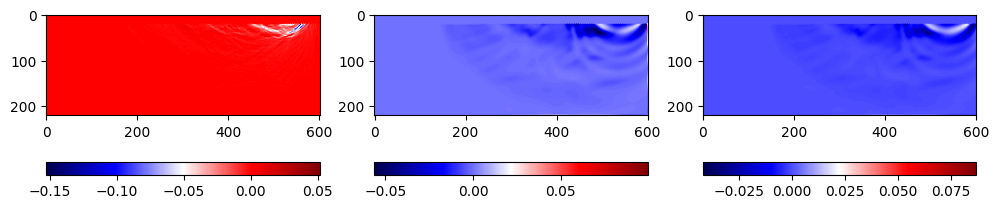

Epoch 380/500, Train Loss: 1.0123089850821998e-06, Valid Loss: 5.655496693179884e-07


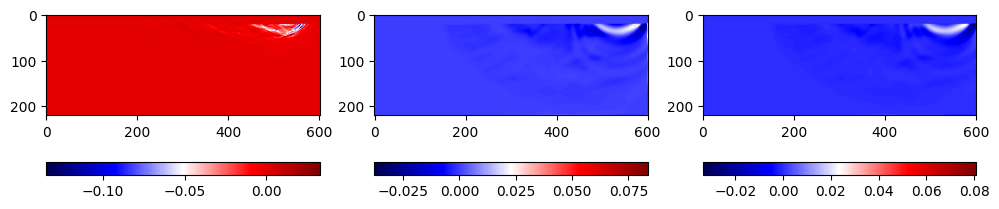

Epoch 390/500, Train Loss: 7.982424463648385e-07, Valid Loss: 4.4303908453002805e-07


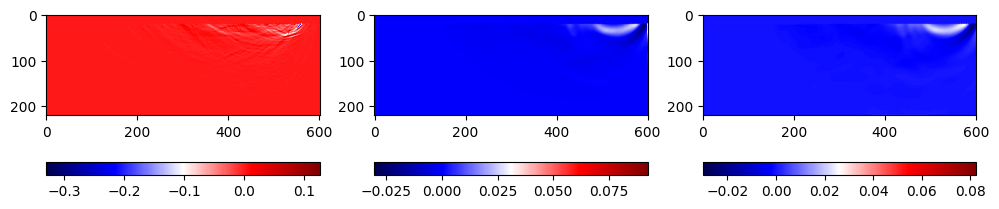

Epoch 400/500, Train Loss: 1.1811133191486078e-06, Valid Loss: 3.301397271116002e-07


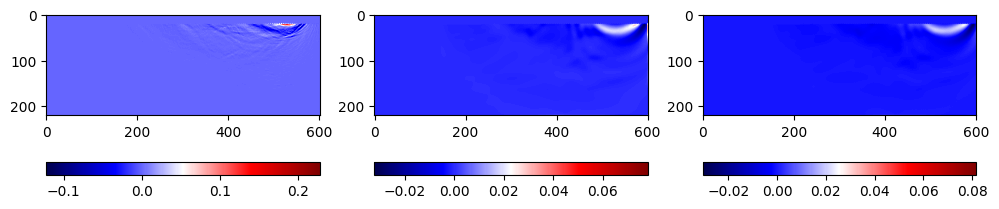

Epoch 410/500, Train Loss: 7.943139408439492e-07, Valid Loss: 4.809476195077877e-07


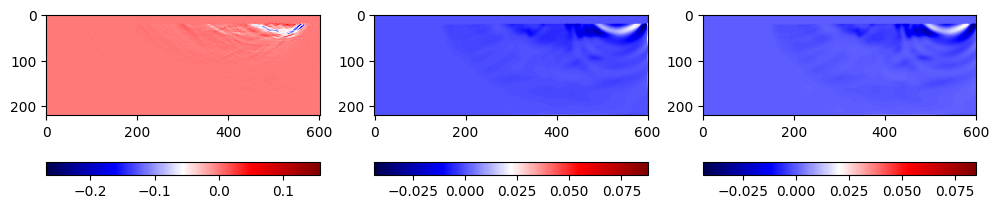

Epoch 420/500, Train Loss: 6.918299888525326e-07, Valid Loss: 4.205704442483693e-07


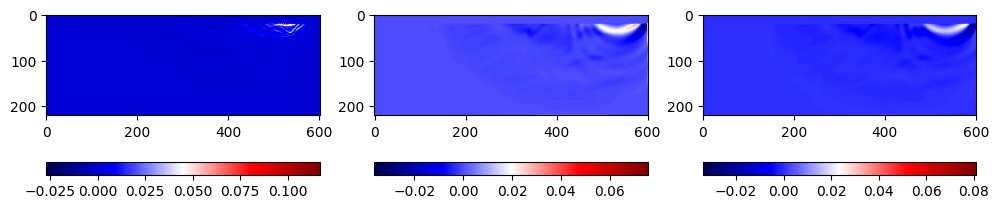

Epoch 430/500, Train Loss: 1.2197781273926012e-06, Valid Loss: 3.4480652288948477e-07


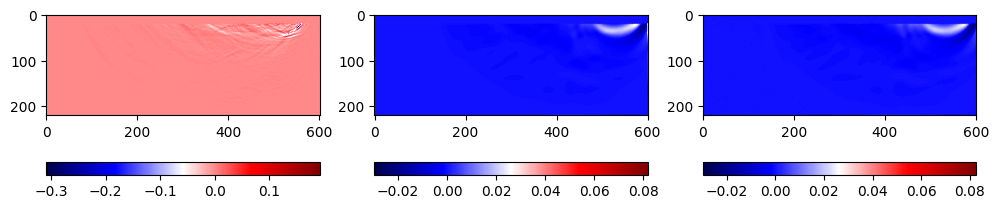

Epoch 440/500, Train Loss: 8.386333547605318e-07, Valid Loss: 3.932721881483303e-07


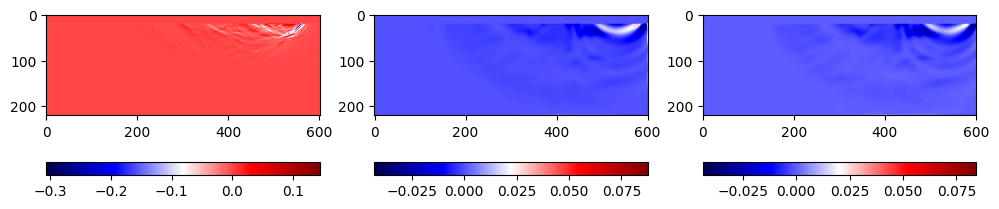

Epoch 450/500, Train Loss: 1.0261914411557882e-06, Valid Loss: 5.978527610750461e-07


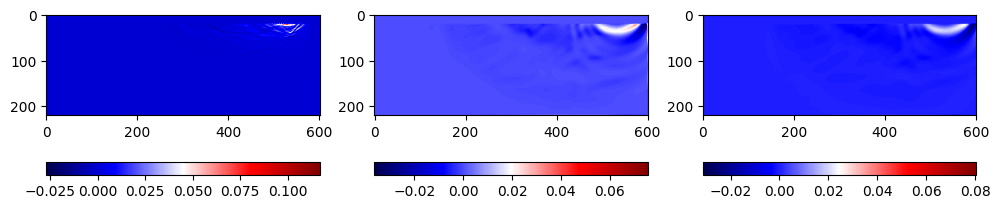

Epoch 460/500, Train Loss: 1.4532045327086962e-06, Valid Loss: 5.666147444571834e-07


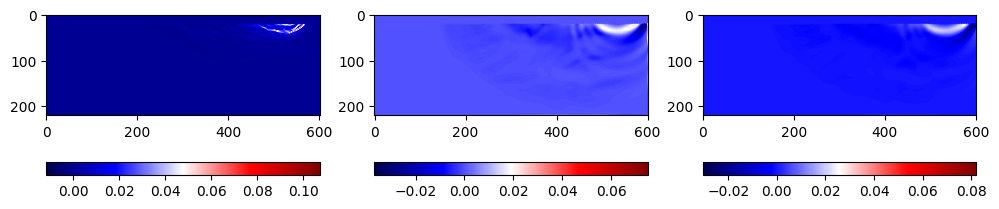

Epoch 470/500, Train Loss: 1.276242329595334e-06, Valid Loss: 6.826196567999432e-07


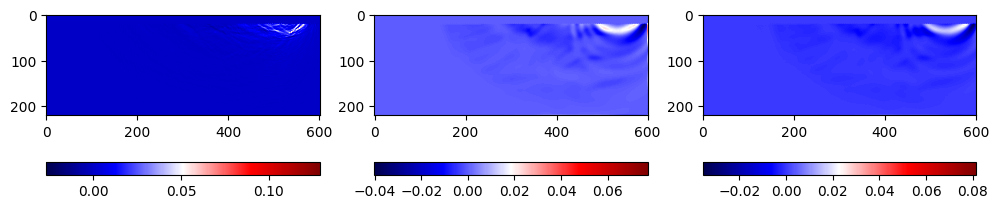

Epoch 480/500, Train Loss: 8.497575265664636e-07, Valid Loss: 2.6719547463471827e-07


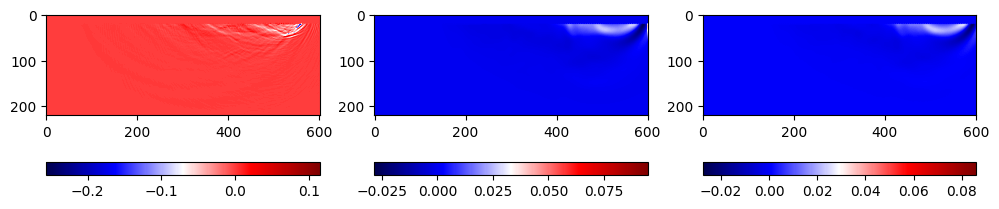

Epoch 490/500, Train Loss: 6.702887134224511e-07, Valid Loss: 6.40573603050143e-07


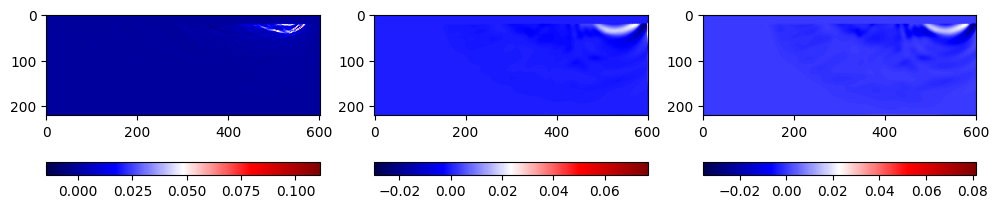

Epoch 500/500, Train Loss: 1.0128792027330746e-06, Valid Loss: 4.706229788098426e-07


In [57]:
import matplotlib.pyplot as plt
train_loss_history = []
valid_loss_history = []
# Function for training the neural network .unsqueeze(1)

epochs=500    
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # print(inputs.shape)
        outputs = model(inputs)
        # print(targets.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # print('check')
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    if (epoch + 1) % 10 == 0:
        # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}"),vmin=-0.1, vmax=0.1
        # print(f'epoch: {epoch+1}')
        fig, axs = plt.subplots(1,3, figsize=(12, 4))
        im0=axs[0].imshow(inputs[7,0].cpu().T, cmap='seismic')
        fig.colorbar(im0, ax=axs[0],orientation='horizontal')
        im1=axs[1].imshow(targets[7,0].cpu().T, cmap='seismic')
        fig.colorbar(im1, ax=axs[1], orientation='horizontal')
        im2=axs[2].imshow(outputs[7,0].detach().cpu().T, cmap='seismic')
        fig.colorbar(im2, ax=axs[2], orientation='horizontal')
        plt.show()
#     print(train_loss)
    
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
        valid_loss /= len(val_loader)
        valid_loss_history.append(valid_loss)

    # scheduler.step()


    # Print the average loss for the epoch , Valid Loss: {valid_loss}
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")
        # print(f'epoch: {epoch+1}')
        # fig, axs = plt.subplots(1,3, figsize=(12, 4))
        # im0=axs[0].imshow(inputs[0,0].cpu().T, cmap='seismic',vmin=-0.1, vmax=0.1)
        # fig.colorbar(im0, ax=axs[0],orientation='vertical')
        # im1=axs[1].imshow(targets[0,0].cpu().T, cmap='seismic',vmin=-0.1, vmax=0.1)
        # fig.colorbar(im1, ax=axs[1], orientation='vertical')
        # im2=axs[2].imshow(outputs[0,0].detach().cpu().T, cmap='seismic',vmin=-0.1, vmax=0.1)
        # fig.colorbar(im2, ax=axs[2], orientation='vertical')
        # plt.show()
    
    # train_losses.append(running_loss/len(train_dataloader))

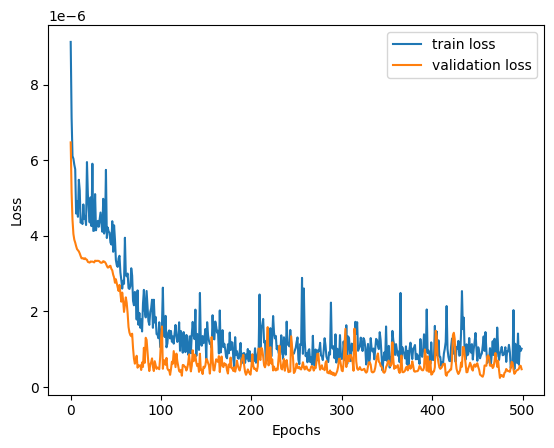

In [58]:

plt.plot(train_loss_history, label='train loss')
plt.plot(valid_loss_history, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

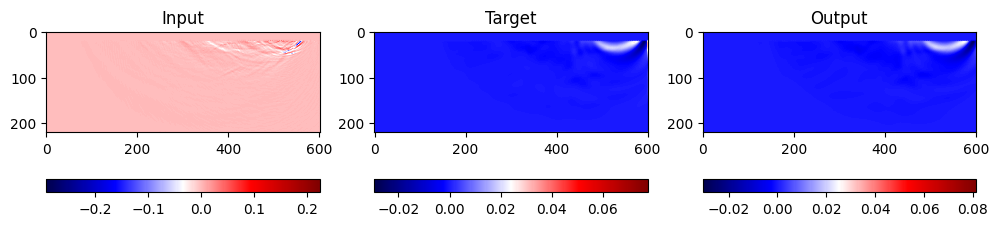

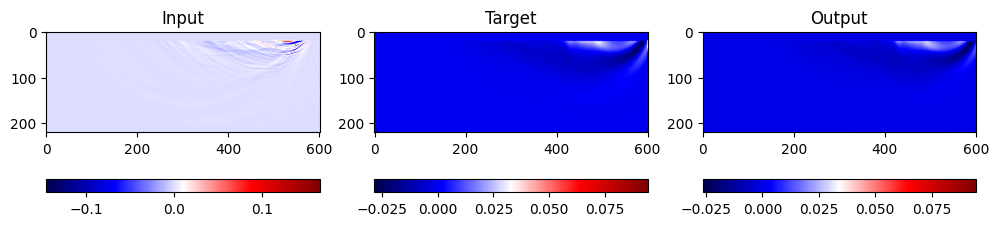

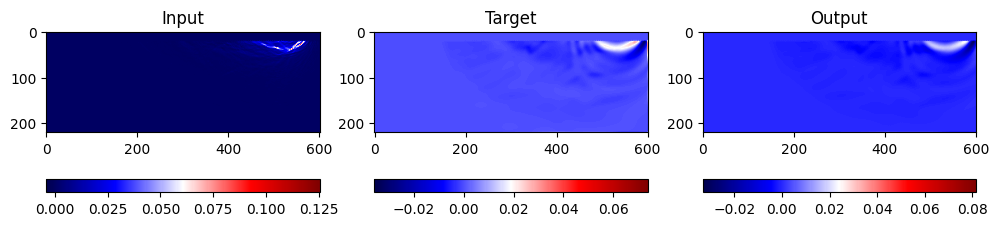

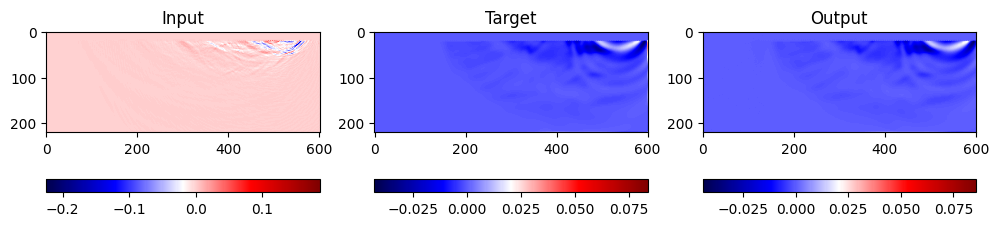

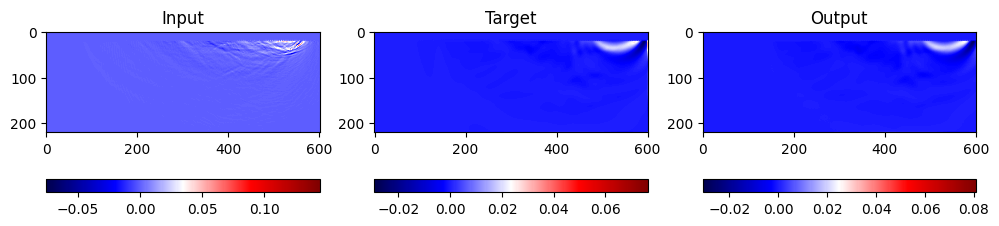

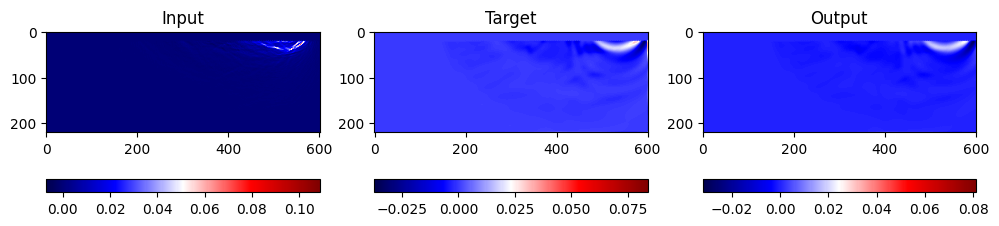

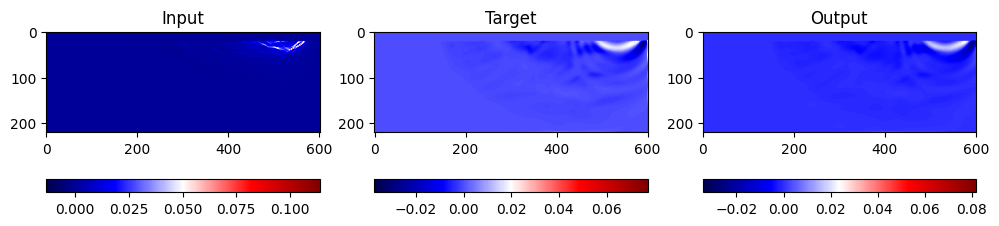

In [60]:
model.eval()
valid_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        valid_loss += loss.item()
        
        for i in range(inputs.size(0)):  # Iterate over batch size
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            im0=axs[0].imshow(inputs[i, 0].cpu().T, cmap='seismic', vmin=targets[i, 0].min(), vmax=targets[i, 0].max())
            fig.colorbar(im0,ax=axs[0],orientation='horizontal')
            axs[0].set_title('Input')
            im1=axs[1].imshow(targets[i, 0].cpu().T, cmap='seismic', vmin=targets[i, 0].min(), vmax=targets[i, 0].max())
            fig.colorbar(im1,ax=axs[1],orientation='horizontal')
            axs[1].set_title('Target')
            im2=axs[2].imshow(outputs[i, 0].detach().cpu().T, cmap='seismic', vmin=targets[i, 0].min(), vmax=targets[i, 0].max())
            fig.colorbar(im2,ax=axs[2],orientation='horizontal')
            axs[2].set_title('Output')
            plt.show()

In [65]:
#Evaluate metrics

model.eval()
with torch.no_grad():
    train_predictions = []
    train_targets = []
    for inputs, targets in train_loader:
        train_predictions.append(model(inputs.to(device)))
        train_targets.append(targets.to(device))
    train_predictions = torch.cat(train_predictions)
    train_targets = torch.cat(train_targets)

    test_predictions = []
    test_targets = []
    for inputs, targets in test_loader:
        test_predictions.append(model(inputs.to(device)))
        test_targets.append(targets.to(device))
    test_predictions = torch.cat(test_predictions)
    test_targets = torch.cat(test_targets)
    
    
        # Calculate the squared differences
    squared_diff = (torch.tensor(train_targets[0]) - torch.tensor(train_predictions[0])) ** 2

    # Calculate the mean of the squared differences
    mse = torch.mean(squared_diff)

    # Take the square root to obtain the RMSE
    rmse = torch.sqrt(mse)

    print("RMSE:", rmse.item())
    
    
       # Calculate the squared differences
    squared_diff = (torch.tensor(test_targets[0]) - torch.tensor(test_predictions[0])) ** 2

    # Calculate the mean of the squared differences
    mse = torch.mean(squared_diff)

    # Take the square root to obtain the RMSE
    rmse = torch.sqrt(mse)

    print("RMSE:", rmse.item())






/tmp/ipykernel_125/390345068.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  squared_diff = (torch.tensor(train_targets[0]) - torch.tensor(train_predictions[0])) ** 2


RMSE: 0.0003124524955637753
RMSE: 0.0005114435334689915


/tmp/ipykernel_125/390345068.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  squared_diff = (torch.tensor(test_targets[0]) - torch.tensor(test_predictions[0])) ** 2


In [62]:
# %%bash
# tar -czf grad_low.tar.gz gradients
# tar -czf grad_high.tar.gz gradients_high

In [61]:
# Save the trained model
torch.save(model.state_dict(), 'cnn_model_final_final_unnorm_test1.pth')
